This notebook simulates the effect of spill-back in CMOS detectors. Spill-back occurs during readout of a CMOS detector, when a large enough amount of charge has accumulated on the floating diffusion mode such that the floating diffusion node and transfer gate are equipotential. Some excess charge may then sit on the transfer gate and may "spill back" over to the pinned photodiode when the transfer gate is reset. This leads to image lag and a nonlinear photon transfer curve.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import copy
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from defect_pixel_funcs import *
from scipy.optimize import curve_fit
import scipy.interpolate
import time
import warnings
warnings.simplefilter('ignore', np.RankWarning)

Look at COSMOS data

In [2]:
# dark_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark'
# dark_stacks = get_stacks(dark_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# gray_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Light'
# gray_stacks = get_stacks(gray_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# for i, stack in enumerate(dark_stacks):
#     stack['mean_img'] = stack['mean_img'].tolist()
#     stack['var_img'] = stack['var_img'].tolist()
#     # Create file dark_stacks.json if it doesn't exist
# with open('gray_stacks.json', 'w') as f:
#     json.dump(gray_stacks, f)
# with open('dark_stacks.json', 'w') as f:
#     json.dump(dark_stacks, f)


In [3]:
# # load dark_stacks.json and gray_stacks.json
# dark_stacks = json.load(open('dark_stacks.json'))
# gray_stacks = json.load(open('gray_stacks.json'))
# # Convert lists to arrays
# for i in range(104):
#     dark_stacks[i]['mean_img'] = np.array(dark_stacks[i]['mean_img'])
#     dark_stacks[i]['var_img'] = np.array(dark_stacks[i]['var_img'])
#     gray_stacks[i]['mean_img'] = np.array(gray_stacks[i]['mean_img'])
#     gray_stacks[i]['var_img'] = np.array(gray_stacks[i]['var_img'])

In [4]:
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
dark_folder = os.path.join(data_folder, 'Dark Mean Images')
light_folder = os.path.join(data_folder, 'Light Mean Images')
dark_files = [f for f in os.listdir(dark_folder) if f.endswith('.fits')]
light_files = [f for f in os.listdir(light_folder) if f.endswith('.fits')]
# Sort files by exposure time
exp_times_light = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files]
exp_times_dark = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in dark_files]
# Sort light files by exposure time
light_files = [x for _, x in sorted(zip(exp_times_light, light_files))]
dark_files = [x for _, x in sorted(zip(exp_times_dark, dark_files))]
# Swap 1st and 2nd entries for both
temp = light_files[0]
light_files[0] = light_files[1]
light_files[1] = temp
# temp = dark_files[0]
# dark_files[0] = dark_files[1]
# dark_files[1] = temp
exp_times = np.array([float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files])
exp_times[0] = exp_times[0] / 1000
# Need to adjust exposure times for actual exposure times.
# Minimum exposure times:
# CMS: 1354 us
# HS_HG_RS: 38 us
# HS_HG_GS: 27028 us
# Row times (exposure times must be integer multiples of these):
# CMS: 150.5 us
# HS_HG_RS: 5.4 us
# HS_HG_GS: 3.3 us
min_exp_time = 1354 / 1000
row_time = 150.5 / 1000
# For any exposure time less than min_exp_time, set to min_exp_time
exp_times[exp_times < min_exp_time] = min_exp_time
# Round exposure times to nearest integer multiple of row_time
exp_times = np.rint(exp_times / row_time) * row_time

subtracted_images = np.zeros((len(light_files), 8120, 8120), dtype=np.float32)
mean_array = np.zeros(len(light_files))
mean_bias_frame_hdul = fits.open(os.path.join(dark_folder, dark_files[0]))
mean_bias_frame = mean_bias_frame_hdul[0].data
for i in range(len(light_files)):
    # print(light_files[i], dark_files[i])
    hdul_light = fits.open(os.path.join(light_folder, light_files[i]))
    # hdul_dark = fits.open(os.path.join(dark_folder, dark_files[i]))
    data_light = hdul_light[0].data
    # data_dark = hdul_dark[0].data
    # subtracted_image = data_light - data_dark
    subtracted_image = data_light - mean_bias_frame
    mean_val = np.mean(subtracted_image)
    subtracted_images[i] = subtracted_image
    mean_array[i] = mean_val
    hdul_light.close()
    # hdul_dark.close()
    print(i, exp_times[i], mean_val)

0 1.3545 2.8621004
1 1.3545 2.8711913
2 4.9665 9.870139
3 9.933 20.615269
4 20.0165 45.372112
5 29.9495 74.10696
6 40.033 105.94066
7 49.966 140.74242
8 60.049499999999995 178.02576
9 69.9825 218.3757
10 80.066 259.5406
11 89.999 303.80792
12 99.932 349.72614
13 110.0155 395.90945
14 119.9485 444.19986
15 130.03199999999998 495.22186
16 139.965 545.0289
17 150.0485 596.6779
18 159.98149999999998 650.34955
19 170.065 703.1076
20 179.998 759.1238
21 189.93099999999998 814.2759
22 200.0145 869.87866
23 220.031 987.3307
24 240.04749999999999 1105.4697
25 260.06399999999996 1225.7692


KeyboardInterrupt: 

In [3]:
max_signal = np.max(mean_array)
linear_regime_low = max_signal * 0.1
linear_regime_high = max_signal * 0.9
linear_regime_low_idx = np.where(mean_array >= linear_regime_low)[0][0]
linear_regime_high_idx = np.where(mean_array <= linear_regime_high)[0][-1]
idx_95_percent = np.where(mean_array <= max_signal * 0.95)[0][-1]
idx_5_percent = np.where(mean_array >= max_signal * 0.05)[0][0]
idx_1_percent = np.where(mean_array >= max_signal * 0.01)[0][0]
idx_thousandth = np.where(mean_array >= max_signal * 0.001)[0][0]
idx_tenthousandth = np.where(mean_array >= max_signal * 0.0001)[0][0]

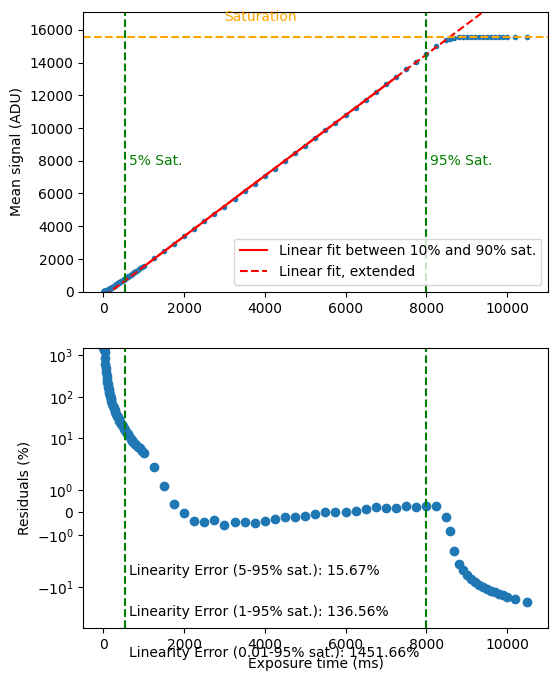

In [5]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, mean_array, 'o', markersize=3)
popt_line = np.polyfit(exp_times[linear_regime_low_idx:linear_regime_high_idx],
                       mean_array[linear_regime_low_idx:linear_regime_high_idx], 1)
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval(popt_line, exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval(popt_line, exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].legend()
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
# Plot residuals
residuals_percent = (mean_array - np.polyval(popt_line, exp_times)) / mean_array * 100
ax[1].plot(exp_times, residuals_percent, 'o')
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
# ax[1].set_ylim(-10, 10)
ax[1].set_yscale('symlog')
max_res_5_to_95 = np.max(residuals_percent[idx_5_percent:idx_95_percent])
min_res_5_to_95 = np.min(residuals_percent[idx_5_percent:idx_95_percent])
max_res_1_to_95 = np.max(residuals_percent[idx_1_percent:idx_95_percent])
min_res_1_to_95 = np.min(residuals_percent[idx_1_percent:idx_95_percent])
# max_res_0_to_95 = np.max(residuals_percent[idx_thousandth:idx_95_percent])
# min_res_0_to_95 = np.min(residuals_percent[idx_thousandth:idx_95_percent])
max_res_0_to_95 = np.max(residuals_percent[idx_tenthousandth:idx_95_percent])
min_res_0_to_95 = np.min(residuals_percent[idx_tenthousandth:idx_95_percent])
linearity_error_5_to_95 = max_res_5_to_95 - min_res_5_to_95
linearity_error_1_to_95 = max_res_1_to_95 - min_res_1_to_95
linearity_error_0_to_95 = max_res_0_to_95 - min_res_0_to_95
# ax[1].text(exp_times[idx_5_percent] + 100, -5, f'Linearity Error (5-95% sat.): {linearity_error_5_to_95:.2f}%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 100, -7, f'Linearity Error (1-95% sat.): {linearity_error_1_to_95:.2f}%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 100, -9, f'Linearity Error (0.01-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -5, f'Linearity Error (5-95% sat.): {linearity_error_5_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -50, f'Linearity Error (1-95% sat.): {linearity_error_1_to_95:.2f}%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 100, -80, f'Linearity Error (0.1-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -500, f'Linearity Error (0.01-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
# ax[0].set_title('Linearity Error: Raw Mean Pixel Values')
plt.show()

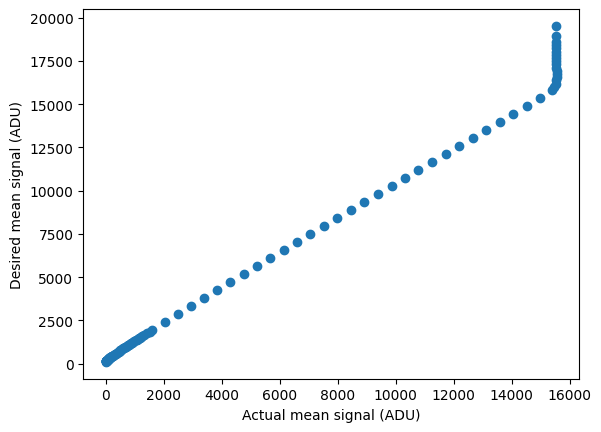

In [6]:
%matplotlib inline
# The values to which we want to correct the signal. Basically, we want to move all values
# such that they fall on the line that best fits the linear regime.
corrected_signal_vals = np.polyval(popt_line, exp_times)
# We want there to be no negative values in the corrected signal
corrected_signal_vals = corrected_signal_vals - popt_line[1]
# Add a bias level
bias_level = 100
corrected_signal_vals += bias_level
corrected_signal_vals = np.concatenate(([100], corrected_signal_vals))
mean_array_with_0 = np.concatenate(([0], mean_array))
plt.plot(mean_array_with_0, corrected_signal_vals, 'o')
plt.xlabel('Actual mean signal (ADU)')
plt.ylabel('Desired mean signal (ADU)')
# plt.title('Desired Linearity Correction')
plt.show()

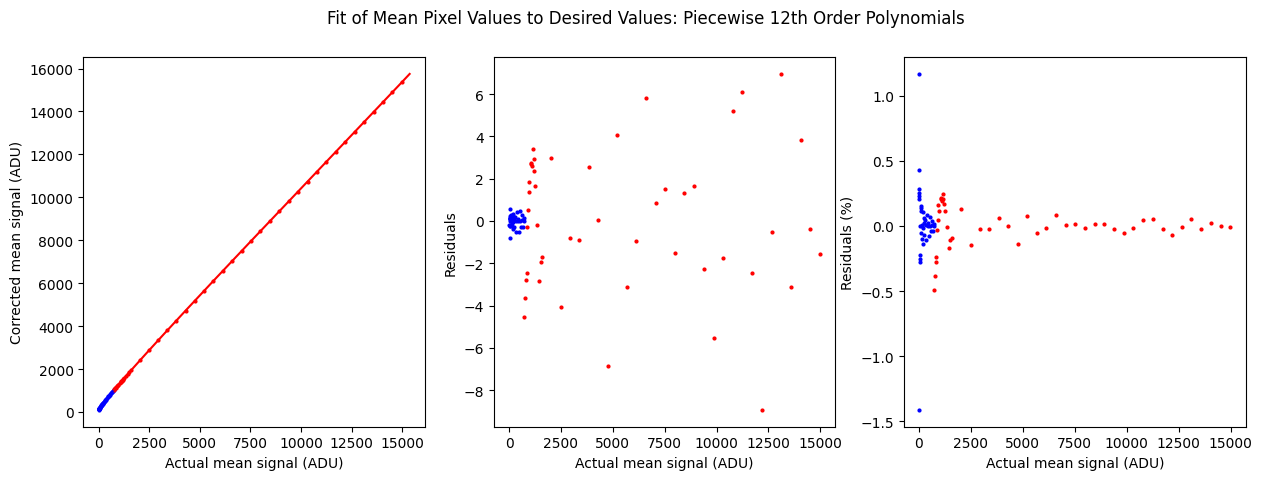

In [7]:
%matplotlib inline
# Fit mean_array_0 vs corrected_signal_vals to a polynomial fit. We want to see
# what order polynomial we should use to fit the data, and to see if a single fit to the mean
# pixel values can do a decent job of correcting the signals at all pixels.
# We will fit the data in two parts: the low end and the mid-to-high end, with some overlap between the fits.
# transition_value = 3000
# order_low = 12
# order_high = 6
# high_cutoff = 60000
transition_value = 750
order_low = 12
order_high = 6
high_cutoff = 15000
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
transition_idx = np.argmax(mean_array_with_0 > transition_value)
high_cutoff_idx = np.argmax(mean_array_with_0 > high_cutoff)
high_cutoff_value = mean_array_with_0[high_cutoff_idx]
weights = np.ones_like(mean_array_with_0)
# Weight lower values higher
# weights[:10] *= 10
popt_poly_low = np.polyfit(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx],
                           order_low-1, w=weights[:transition_idx])
popt_poly_high = np.polyfit(mean_array_with_0[transition_idx-1:high_cutoff_idx],
                            corrected_signal_vals[transition_idx-1:high_cutoff_idx],
                            order_high-1, w=weights[transition_idx-1:high_cutoff_idx])
residuals_low = (corrected_signal_vals[:transition_idx] - np.polyval(popt_poly_low, mean_array_with_0[:transition_idx]))
residuals_high = (corrected_signal_vals[transition_idx-1:high_cutoff_idx] - np.polyval(popt_poly_high, mean_array_with_0[transition_idx-1:high_cutoff_idx]))
ax[0].plot(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx], 'bo', markersize=2,)
ax[0].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], corrected_signal_vals[transition_idx-1:high_cutoff_idx], 'ro', markersize=2)
low_signal_vals = np.arange(0, transition_value, 1)
high_signal_vals = np.arange(transition_value, high_cutoff_value, 1)
ax[0].plot(low_signal_vals, np.polyval(popt_poly_low, low_signal_vals), 'blue')
ax[0].plot(high_signal_vals, np.polyval(popt_poly_high, high_signal_vals), 'red')
ax[0].set_xlabel('Actual mean signal (ADU)')
ax[0].set_ylabel('Corrected mean signal (ADU)')
# ax[0].set_title('Polynomial Fit')
ax[1].plot(mean_array_with_0[:transition_idx], residuals_low[:transition_idx], 'bo', markersize=2)
ax[1].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], residuals_high, 'ro', markersize=2)
ax[1].set_xlabel('Actual mean signal (ADU)')
ax[1].set_ylabel('Residuals')
# ax[1].set_title('Polynomial Fit Residuals')
residuals_percent_low = residuals_low[1:] / (corrected_signal_vals[1:transition_idx] - bias_level) * 100
residuals_percent_high = residuals_high / (corrected_signal_vals[transition_idx-1:high_cutoff_idx] - bias_level) * 100
ax[2].plot(mean_array_with_0[1:transition_idx], residuals_percent_low, 'bo', markersize=2)
ax[2].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], residuals_percent_high, 'ro', markersize=2)
ax[2].set_xlabel('Actual mean signal (ADU)')
ax[2].set_ylabel('Residuals (%)')
# ax[1].set_title('Polynomial Fit Residuals')
plt.suptitle('Fit of Mean Pixel Values to Desired Values: Piecewise 12th Order Polynomials')
plt.show()

Text(0, 0.5, 'Desired mean signal (ADU)')

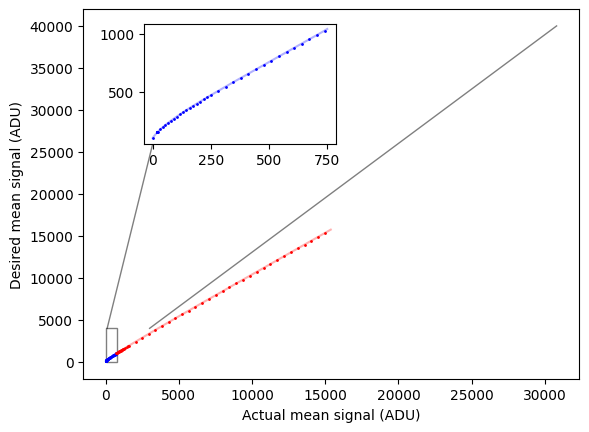

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(low_signal_vals, np.polyval(popt_poly_low, low_signal_vals), 'blue', alpha=0.3)
ax.plot(high_signal_vals, np.polyval(popt_poly_high, high_signal_vals), 'red', alpha=0.3)
ax.plot(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx], 'bo', markersize=1)
ax.plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], corrected_signal_vals[transition_idx-1:high_cutoff_idx], 'ro', markersize=1)
# Put an inset plot in the top left corner showing just the range of 0 to 5000
ax_inset = plt.axes([0.22, 0.6, 0.3, 0.25])
ax_inset.plot(low_signal_vals, np.polyval(popt_poly_low, low_signal_vals), 'blue', alpha=0.3)
ax_inset.plot(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx], 'bo', markersize=1)
# Put square around the part that goes to the inset plot
rect = plt.Rectangle((0, 0), transition_value, 4000, fill=False, color='k', alpha=0.5)
ax.add_patch(rect)
# Add lines showing rectangle going up to inset plot
ax.plot([100, 5200], [4000, 40000], 'k', alpha=0.5, linewidth=1)
ax.plot([3000, 30800], [4000, 40000], 'k', alpha=0.5, linewidth=1)
ax.set_xlabel('Actual mean signal (ADU)')
ax.set_ylabel('Desired mean signal (ADU)')

In [9]:
def correct_images(image_stack, coeffs, transition_value, high_cutoff, bits, order_low, bias_frame=None, verbose=False):
    corrected_stack = np.zeros_like(image_stack, dtype=np.uint16)
    order_high = len(coeffs) - order_low
    if bias_frame is not None:
        image_stack = image_stack - bias_frame
    for i, frame in enumerate(image_stack):
        corrected_frame = np.zeros_like(frame, dtype=float)
        low_vals_frame = np.zeros_like(frame)
        low_vals_frame[frame <= transition_value] = frame[frame <= transition_value]
        low_vals_true_frame = frame <= transition_value
        high_vals_frame = np.zeros_like(frame)
        high_vals_frame[(frame > transition_value) & (frame < high_cutoff)] = frame[(frame > transition_value) & (frame < high_cutoff)]
        high_vals_true_frame = (frame > transition_value) & (frame < high_cutoff)
        saturated_vals_true_frame = frame >= high_cutoff
        for j in range(order_low - 1):
            corrected_frame += coeffs[j] * low_vals_frame.astype(float) ** (order_low - 1 - j)
        for j in range(order_high - 1):
            corrected_frame += coeffs[j + order_low] * high_vals_frame.astype(float) ** (order_high - 1 - j)
            # For saturated values, set the corrected value to the correction of high_cutoff
            corrected_frame += coeffs[j + order_low] * (high_cutoff * saturated_vals_true_frame).astype(float) ** (order_high - 1 - j)
        # Add the correct constant term
        corrected_frame += coeffs[order_low - 1] * low_vals_true_frame
        corrected_frame += coeffs[-1] * high_vals_true_frame
        corrected_frame += coeffs[-1] * saturated_vals_true_frame
        # Bound corrected_frame between 0 and 2**bits - 1
        corrected_frame[corrected_frame < 0] = 0
        corrected_frame[corrected_frame > 2**bits - 1] = 2**bits - 1
        # Make NaNs equal to 2 ** bits - 1
        corrected_frame[np.isnan(corrected_frame)] = 2 ** bits - 1
        corrected_stack[i] = np.rint(corrected_frame).astype(np.uint16)
        if verbose:
            print(i, np.median(corrected_stack[i]))
    return corrected_stack

In [10]:
coeffs_mean = np.concatenate((popt_poly_low, popt_poly_high))
corrected_mean_array = correct_images(mean_array_with_0[1:], coeffs_mean, transition_value, high_cutoff, 16, order_low=order_low)
max_signal = np.max(corrected_mean_array) - bias_level
idx_95_percent = np.where(corrected_mean_array - bias_level <= max_signal * 0.95)[0][-1]
idx_50_percent = np.where(corrected_mean_array - bias_level <= max_signal * 0.5)[0][-1]
idx_5_percent = np.where(corrected_mean_array - bias_level >= max_signal * 0.05)[0][0]
idx_1_percent = np.where(corrected_mean_array - bias_level >= max_signal * 0.01)[0][0]
idx_thousandth = np.where(corrected_mean_array - bias_level >= max_signal * 0.001)[0][0]
idx_tenthousandth = np.where(corrected_mean_array - bias_level >= max_signal * 0.0001)[0][0]

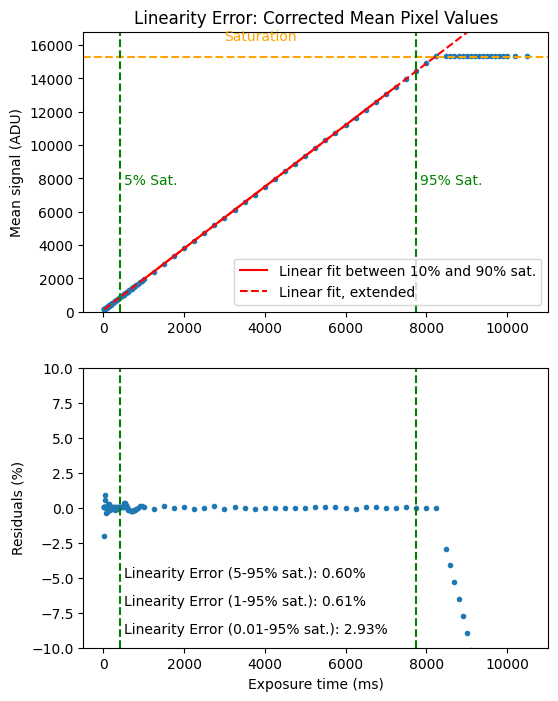

In [11]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, corrected_mean_array, 'o', markersize=3)
# Fit to line with intercept bias_level
popt_1, pcov_1 = curve_fit(lambda x, m: m * x + bias_level, exp_times[idx_5_percent:idx_95_percent],
                   corrected_mean_array[idx_5_percent:idx_95_percent])
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_1[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_1[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].legend()
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
# Plot residuals
residuals_percent = (corrected_mean_array - np.polyval([popt_1[0], bias_level], exp_times)) / (corrected_mean_array - bias_level) * 100
ax[1].plot(exp_times, residuals_percent, 'o', markersize=3)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
max_res_5_to_95 = np.max(residuals_percent[idx_5_percent:idx_95_percent])
min_res_5_to_95 = np.min(residuals_percent[idx_5_percent:idx_95_percent])
max_res_1_to_95 = np.max(residuals_percent[idx_1_percent:idx_95_percent])
min_res_1_to_95 = np.min(residuals_percent[idx_1_percent:idx_95_percent])
# max_res_0_to_95 = np.max(residuals_percent[idx_thousandth:idx_95_percent])
# min_res_0_to_95 = np.min(residuals_percent[idx_thousandth:idx_95_percent])
max_res_0_to_95 = np.max(residuals_percent[idx_tenthousandth:idx_95_percent])
min_res_0_to_95 = np.min(residuals_percent[idx_tenthousandth:idx_95_percent])
linearity_error_5_to_95 = max_res_5_to_95 - min_res_5_to_95
linearity_error_1_to_95 = max_res_1_to_95 - min_res_1_to_95
linearity_error_0_to_95 = max_res_0_to_95 - min_res_0_to_95
ax[1].text(exp_times[idx_5_percent] + 100, -5, f'Linearity Error (5-95% sat.): {linearity_error_5_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -7, f'Linearity Error (1-95% sat.): {linearity_error_1_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -9, f'Linearity Error (0.01-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
ax[0].set_title('Linearity Error: Corrected Mean Pixel Values')
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 100
test_subtracted_images = subtracted_images[:, 4000:4000+square_size, 4000:4000+square_size]
corrected_test_images = correct_images(test_subtracted_images, coeffs_mean, transition_value, high_cutoff, 16, order_low=order_low)
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, square_size, 5))
for i in range(square_size):
    for j in range(square_size):
        pixel_corrected_values = corrected_test_images[:, i, j]
        pixel_residuals = (pixel_corrected_values - np.polyval([popt_1[0], bias_level], exp_times))
        pixel_residuals_percent =  pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i * square_size + j < 50:
            ax[0].plot(exp_times, pixel_corrected_values, 'o', markersize=3)
            ax[1].plot(exp_times, pixel_residuals_percent, 'o', markersize=1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_thousandth] if not np.isinf(pixel_residuals[idx_thousandth]) else np.nan
        # err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_1[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_1[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
# ax[1].text(exp_times[idx_5_percent] + 1000, 8, r'$\mu_{95\%}: $' + format(mu_errs[0], '.2f') + '%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 200, -7, f'Avg. Linearity Error (1-95% sat.): {avg_lin_err_1_to_95:.2f}%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 200, -9, f'Avg. Linearity Error (0.01-95% sat.): {avg_lin_err_0_to_95:.2f}%', ha='left')
num_frames = 25
gain = 1
read_noise = 8
# Expected noise from shot noise, read noise, and quantization noise (which is 1/12 corrected ADU)
expected_errs = np.sqrt((gain * (np.polyval([popt_1[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_1[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label='Expected error')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Mean Correction Applied to 10,000 Individual Pixels')
plt.show()
# means_list = np.array([corrected_mean_array[i] - bias_level for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
means_list = np.array([corrected_mean_array[i] - bias_level for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_thousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / means_list * 100
# sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_thousandth]]


In [ ]:
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
# column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.1% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Mean Correction Applied to 10,000 Individual Pixels')
# Display the table
plt.show()

Indeed, it is necessary to do totally separate nonlinearity corrections for every pixel. And you cannot just use a correction for each row or each pixel. Even directly adjacent pixels can be very different.

In [21]:
%matplotlib qt
# Need to figure out how to weed out bad pixels during calibration.
# Otherwise their weird curves will just result in a really weird calibration
# that may temporaily hide their weird behavior
# Some behaviors that should disqualify pixels:
# 1) They very quickly go from very little signal to saturation
# 2) They don't even come close to saturating
# 3) Their response w/r/t exposure time is not monotonically increasing.
# The 3rd one seems to be included in the other 2, but it's worth checking for.
signal_shootup_cutoff = 1000
lazy_pix_signal_cutoff = 2500
# plt.plot(exp_times, subtracted_images[:, 7184, 50], label='Good pixel')
# plt.plot(exp_times, subtracted_images[:, 7069, 2422], label='Good pixel behind a permanent scratch')
# plt.plot(exp_times, subtracted_images[:, 5, 6700], label='"Negative" pixel')
plt.plot(exp_times, subtracted_images[:, 80, 0], label='"Sudden Jump" pixel')
plt.plot(exp_times, subtracted_images[:, 0, 1000], label='"Lazy" pixel')
plt.plot(exp_times, subtracted_images[:, 800, 1000], label='"Lazy" pixel')
# plt.plot(exp_times, subtracted_images[:, 1257, 492], label='Nonmonotonic pixel')
# plt.plot(exp_times, subtracted_images[:, 4000, 2246], label='Sudden jump pixel')
# for i in range(10):
#     plt.scatter(exp_times, subtracted_images[:, 4000 + i, 994], label=i, s=3)
plt.legend()
plt.xlabel('Exposure time (ms)')
plt.ylabel('Signal (ADU)')
plt.title('Examples of Bad Pixels')
plt.show()

In [21]:
order_low = 12
order_high = 6
transition_value = 750
high_cutoff = 15000
coeff_array = np.zeros((order_low + order_high, 8120, 8120))

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
num_plots = 0
for i in range(2000):
    for j in range(8120):
        # if j == 0:
        #     print(i, j)
        mean_vals = subtracted_images[:, i, j]
        mean_vals = np.concatenate(([0], mean_vals))
            
        # Identify defect pixels. First, lazy pixels.
        if np.max(mean_vals) < lazy_pix_signal_cutoff:
            print('Lazy Pixel at ', i, j)
            # Make the coefficients NaNs if pixel is lazy
            coeff_array[:, i, j] = np.nan
            continue
        # Identify pixels that act weirdly after saturation (happens for HSHGGS mode)
        if mean_vals[-1] < lazy_pix_signal_cutoff:
            print('Pixel shoots back down after saturation at ', i, j)
            # Make the coefficients NaNs if pixel is lazy
            coeff_array[:, i, j] = np.nan
            continue
        # Also for the HSHGGS mode, sometime the pixel will start increasing, then go to a negative value
        # before ramping up again. Since the minimum exposure time already gives a mean value of ~20, we
        # can safely say that any pixel that goes negative is defective.
        if np.any(mean_vals < 0):
            print('Negative pixel at ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        # Next, pixels whose signal suddenly shoots up at some exposure time
        if np.any(np.diff(mean_vals) > signal_shootup_cutoff):
            print('Sudden jump pixel at ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        # Finally, pixels whose signals are not monotonically increasing, at least where the sensor
        # as a whole should be in the linear regime (so noise wouldn't cause such behavior)
        if not np.all(np.diff(mean_vals[linear_regime_low_idx:linear_regime_high_idx]) > 0):
            print('Non-monotonically increasing pixel at ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        # Certain rows/columns are defective all the way across, and sometimes the methods
        # above won't catch the entire row/column. This is a catch-all for those. Column 2246 only for HSHGGS.
        if i == 1257 or j == 994 or j == 2246:
            print('Defect row or column ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        
        # Split the data into low and high regimes for fitting
        transition_idx = np.argmax(mean_vals > transition_value)
        # Don't want the fit to go above saturation. high_cutoff is a bit
        # below saturation, so we fit to just beyond that point.
        if np.max(mean_vals) > high_cutoff:
            high_cutoff_idx = np.argmax(mean_vals > high_cutoff)
            high_cutoff_value = mean_vals[high_cutoff_idx]
        # If pixel isn't reaching saturation, fit to the highest value
        else:
            high_cutoff_idx = len(mean_vals) - 2
            high_cutoff_value = mean_vals[high_cutoff_idx]
        weights = np.ones_like(mean_vals[:transition_idx+2])
        # weights[:10] *= 10
        # weights = 1 / (1 + np.sqrt(abs(mean_vals[:transition_idx+2])))
        popt_poly_low = np.polyfit(mean_vals[:transition_idx+2], corrected_signal_vals[:transition_idx+2], deg=order_low-1, w=weights)
        popt_poly_high = np.polyfit(mean_vals[transition_idx-1:high_cutoff_idx+2],
                                    corrected_signal_vals[transition_idx-1:high_cutoff_idx+2], deg=order_high-1)
        coeff_array[:, i, j] = np.concatenate((popt_poly_low, popt_poly_high))
        residuals_low = corrected_signal_vals[1:transition_idx+2] - np.polyval(popt_poly_low, mean_vals[1:transition_idx+2])
        residuals_high = corrected_signal_vals[transition_idx-1:high_cutoff_idx+2] - np.polyval(popt_poly_high, mean_vals[transition_idx-1:high_cutoff_idx+2])
        residuals_percent_low = residuals_low / (corrected_signal_vals[1:transition_idx+2] - bias_level) * 100
        residuals_percent_high = residuals_high / (corrected_signal_vals[transition_idx-1:high_cutoff_idx+2] - bias_level) * 100
        low_vals_plot = np.arange(-10, transition_value, 0.5)
        high_vals_plot = np.arange(transition_value, high_cutoff, 0.5)
        all_ints_low = np.arange(0, transition_value, 1)
        if num_plots < 30:
            ax[0].plot(mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Pixel {i}, {j}')
            ax[0].plot(low_vals_plot, np.polyval(popt_poly_low, low_vals_plot), c=ax[0].lines[-1].get_color())
            ax[0].plot(high_vals_plot, np.polyval(popt_poly_high, high_vals_plot), c=ax[0].lines[-1].get_color())
            ax[0].plot(all_ints_low, np.polyval(popt_poly_low, all_ints_low), c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[1:transition_idx+2], residuals_low, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[transition_idx-1:high_cutoff_idx+2], residuals_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[1:transition_idx+2], residuals_percent_low, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[transition_idx-1:high_cutoff_idx+2], residuals_percent_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            num_plots += 1

# ax[0].legend()
ax[0].set_xlabel('Mean Pixel Signal (ADU)')
ax[0].set_ylabel('Corrected Mean Pixel Signal (ADU)')
# ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_xlabel('Mean signal (ADU)')
ax[1].set_ylabel('Residuals of Fit (Adu)')
ax[1].set_ylim(-100, 100)
ax[2].set_xlabel('Mean signal (ADU)')
ax[2].set_ylabel('Residuals of Fit (%)')
ax[2].set_ylim(-100, 100)
# label_plot(gray_stacks[0])
plt.show()

In [12]:
# Load coefficient array
coeff_array = fits.getdata('/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Calibration Data/coeff_array_CMS.fits')
defect_pix_array = 1 - np.isnan(coeff_array[0]).astype(int)
hdu = fits.PrimaryHDU(defect_pix_array)
hdu.writeto('defect_map_calibration_CMS.fits', overwrite=True)

In [ ]:
# Load corrected images
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
light_folder = os.path.join(data_folder, 'Light Verification Mean Images/Calibrated Data')
light_files = [f for f in os.listdir(light_folder) if f.endswith('.fits')]
# Sort files by exposure time
exp_times_light = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files]
light_files = [x for _, x in sorted(zip(exp_times_light, light_files))]
# Swap 1st and 2nd entries for both
temp = light_files[0]
light_files[0] = light_files[1]
light_files[1] = temp


corrected_images = np.zeros((len(light_files), 8120, 8120), dtype=np.float32)
corrected_image_means = np.zeros(len(light_files), dtype=np.float32)
for i in range(len(light_files)):
    hdul_light = fits.open(os.path.join(light_folder, light_files[i]))
    corrected_images[i] = hdul_light[0].data
    corrected_image_means[i] = np.mean(corrected_images[i])
    hdul_light.close()
    # hdul_dark.close()
    print(i, corrected_image_means[i])

In [14]:
# corrected_images = correct_images(subtracted_images[-5:,:,:], coeff_array[:,:,:],
#                                   transition_value=transition_value, high_cutoff=high_cutoff,
#                                   bits=14, verbose=True, order_low=order_low)
# A map with NaNs wherever coeff_array[0] is NaN and ones elsewhere
# nan_map = np.ones_like(coeff_array[0,:,:])
# nan_map[np.isnan(coeff_array[0,:,:])] = np.nan
# corrected_images = corrected_images * nan_map
# corrected_image_means = np.nanmean(corrected_images, axis=(1,2))
# print(corrected_image_means)
# Fit to line with intercept of bias_level
popt_2, pcov_2 = curve_fit(lambda x, m: m * x + bias_level, exp_times[linear_regime_low_idx:linear_regime_high_idx],
                          corrected_image_means[linear_regime_low_idx:linear_regime_high_idx])


In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 100
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, 8120, 5))
for i in range(square_size):
    print(i)
    for j in range(8120):
        if np.isnan(coeff_array[0, i, j]):
            err_vals[i, j] = np.nan
            # print('Skipping pixel ', i, j)
            continue
        pixel_corrected_values = corrected_images[:, i, j]
        pixel_residuals = pixel_corrected_values - np.polyval([popt_2[0], bias_level], exp_times)
        pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i < 100 and j > 2000 and j <= 2001:
            ax[0].plot(exp_times, pixel_corrected_values, 'o', markersize=2)
            ax[1].plot(exp_times, pixel_residuals_percent, 'o', markersize=0.1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_thousandth] if not np.isinf(pixel_residuals[idx_thousandth]) else np.nan
        err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_2[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_2[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
# Add curves showing expected linearity error from shot noise plus read noise
num_frames = 11
gain = 4
read_noise = 2
expected_errs = np.sqrt((gain * (np.polyval([popt_2[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_2[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label=r'$\sigma_{expected}$')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Individual Pixel Corrections')
plt.show()
corrected_means_list = np.array([corrected_image_means[i] - bias_level
                                              for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
# corrected_means_list = np.array([corrected_image_means[i] - bias_level
#                                               for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / corrected_means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / corrected_means_list * 100
# sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_thousandth]]
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]

In [90]:
# np.nanmax(err_vals[:,:,2])
# # Get indices of max
# np.unravel_index(np.nanargmax(err_vals[:,:,2]), err_vals[:,:,2].shape)
# plt.hist(err_vals[:,:,2].flatten(), bins=100)
# plt.yscale('log')
# plt.show()

In [ ]:
%matplotlib inline
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.1% Sat."]
# column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Individual Pixel Calibrations')
# Display the table
plt.show()

In [96]:
# Save coefficient array as a fits file
hdu = fits.PrimaryHDU(coeff_array)
hdu.writeto('coeff_array_HSHGGS.fits', overwrite=True)
defect_pix_array = 1 - np.isnan(coeff_array[0]).astype(int)
hdu = fits.PrimaryHDU(defect_pix_array)
hdu.writeto('defect_map_calibration_HSHGGS.fits', overwrite=True)

Process for conducting calibration on new images:
1) Find the average uncalibrated dark frame, denoted D_raw
2) Subtract the mean bias frame used to construct the calibration, B_base from D_raw to get D_sub. 
3) Apply calibration (run correct_images with appropriate coefficient array) to D_sub to get the calibrated dark frame D_cal.
4) For each raw light frame F_raw, subtract B_base from F_raw to get F_sub.
5) Apply calibration to F_sub to get F_int.
6) Subtract D_cal from F_int to get the final calibrated, dark-subtracted frame F_cal. Apply the same flat-fielding techniques using F_cal frames.

If you're applying the calibration to analyze dark frames or bias frames, you may want to collect a new set of bias frames, and treat the average of these raw bias frames as D_raw. Then apply the calibration the same way as above, replacing light frames with your individual bias or dark frames.

In [ ]:
raw_xray_peak = 4.049 * 6003
calibrated_xray_peak = correct_images(np.array([raw_xray_peak]), coeffs_mean, transition_value, high_cutoff, 16, order_low=order_low)
calibrated_xray_gain = calibrated_xray_peak / raw_xray_peak * 4.049
print(calibrated_xray_gain)

In [21]:
# For every fits file corresponding to an image stack, calculate the average image and save this as a new fits file with the same header
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest'
mean_images_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images'
fits_files = [f for f in os.listdir(data_folder) if f.endswith('.fits')]
for i, file in enumerate(fits_files[:]):
    print(i, file)
    hdul = fits.open(os.path.join(data_folder, file))
    data = hdul[0].data
    mean_img = np.mean(data, axis=0).astype(np.float32)
    # Save the mean image as a new fits file, but use the same header
    hdu = fits.PrimaryHDU(mean_img)
    # if 'dark' in file:
    #     folder = mean_images_folder + '/Dark Mean Images'
    #     hdu.writeto(os.path.join(folder, f'mean_{file}'), overwrite=True)
    # elif 'light' in file:
    # folder = mean_images_folder + '/Light Mean Images'
    hdu.writeto(os.path.join(mean_images_folder, f'mean_{file}'), overwrite=True)
    hdul.close()

0 HSHG_RS_dark_760ms_-25C 2024-10-11 03_24_22.fits
1 HSHG_RS_dark_360ms_-25C 2024-10-11 03_15_45.fits
2 HSHG_RS_dark_190ms_-25C 2024-10-11 03_12_31.fits
3 HSHG_RS_dark_400ms_-25C 2024-10-11 03_16_33.fits
4 HSHG_RS_dark_460ms_-25C 2024-10-11 03_17_47.fits
5 HSHG_RS_dark_130ms_-25C 2024-10-11 03_10_35.fits
6 HSHG_RS_dark_240ms_-25C 2024-10-11 03_13_33.fits
7 HSHG_RS_dark_540ms_-25C 2024-10-11 03_19_31.fits
8 HSHG_RS_dark_200ms_-25C 2024-10-11 03_12_52.fits
9 HSHG_RS_dark_1750ms_-25C 2024-10-11 03_29_45.fits
10 HSHG_RS_dark_1000ms_-25C 2024-10-11 03_27_41.fits
11 HSHG_RS_dark_50ms_-25C 2024-10-11 03_08_11.fits
12 HSHG_RS_dark_10ms_-25C 2024-10-11 03_07_02.fits
13 HSHG_RS_dark_520ms_-25C 2024-10-11 03_19_05.fits
14 HSHG_RS_dark_30ms_-25C 2024-10-11 03_07_36.fits
15 HSHG_RS_dark_800ms_-25C 2024-10-11 03_25_26.fits
16 HSHG_RS_dark_850ms_-25C 2024-10-11 03_25_58.fits
17 HSHG_RS_dark_300ms_-25C 2024-10-11 03_14_37.fits
18 HSHG_RS_dark_2000ms_-25C 2024-10-11 03_30_37.fits
19 HSHG_RS_dark_120ms_

A few notes on various nonlinear calibration techniques:
- Polynomial fits: even at high order, don't do a good job of capturing low-signal response. Easy to implement and fast on GPUs.
- Polynomial fits with square root/power law: more complicated, better than polynomial, but still not great for low signal levels
- Rational fits: do better at capturing low-signal response, but have the potential to produce roots in the demoninator that make the calibrated number of photoelectrons go to infinity
- Cubic Splines: obviously fit the data exactly, but introduce many areas of the parameter space of signal levels where increasing signal levels calibrate to decreasing photoelectron value (cubic splines are not monotonic). A bit more complicated to implement on a GPU (can think of cubic splines for one pixel as O(100) separate cubic polynomials), but it's manageable.
- Linear Interpolation: like cubic splines, calibration is more complicated to implement on GPU, but a little less demanding. Will naturally fit the calibration data exactly, and will always be monotonically increasing, assuming the calibration data is.

In [ ]:
# Verification of calibration
verification_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
dark_folder_2 = os.path.join(verification_folder, 'Dark Verification Mean Images')
light_folder_2 = os.path.join(verification_folder, 'Light Verification Mean Images')
dark_files_2 = [f for f in os.listdir(dark_folder_2) if f.endswith('.fits')]
light_files_2 = [f for f in os.listdir(light_folder_2) if f.endswith('.fits')]
# Sort files by exposure time
exp_times_light_2 = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files_2]
exp_times_dark_2 = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in dark_files_2]
# Sort light files by exposure time
light_files_2 = [x for _, x in sorted(zip(exp_times_light_2, light_files_2))]
dark_files_2 = [x for _, x in sorted(zip(exp_times_dark_2, dark_files_2))]
# Swap 1st and 2nd entries for both so 1 us comes before 1 ms
temp = light_files_2[0]
light_files_2[0] = light_files_2[1]
light_files_2[1] = temp
temp = dark_files_2[0]
dark_files_2[0] = dark_files_2[1]
dark_files_2[1] = temp
exp_times_2 = np.array([float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files_2])
exp_times_2[0] = exp_times_2[0] / 1000
# Need to adjust exposure times for actual exposure times.
# Minimum exposure times:
# CMS: 1354 us
# HS_HG_RS: 38 us
# HS_HG_GS: 27028 us
# Row times (exposure times must be integer multiples of these):
# CMS: 150.5 us
# HS_HG_RS: 5.4 us
# HS_HG_GS: 3.3 us
min_exp_time = 1354 / 1000
row_time = 150.5 / 1000
# For any exposure time less than min_exp_time, set to min_exp_time
exp_times_2[exp_times_2 < min_exp_time] = min_exp_time
# Round exposure times to nearest integer multiple of row_time
exp_times_2 = np.rint(exp_times_2 / row_time) * row_time

subtracted_images_2 = np.zeros((len(light_files_2), 8120, 8120), dtype=np.float32)
mean_array_2 = np.zeros(len(light_files_2))
mean_bias_frame_2_hdul = fits.open(os.path.join(dark_folder_2, dark_files_2[0]))
mean_bias_frame_2 = mean_bias_frame_2_hdul[0].data
mean_bias_frame_2_hdul.close()
mean_bias_frame_2 = mean_bias_frame_2 - mean_bias_frame
for i in range(len(light_files_2)):
    hdul_light = fits.open(os.path.join(light_folder_2, light_files_2[i]))
    # hdul_dark = fits.open(os.path.join(dark_folder_2, dark_files_2[i]))
    data_light = hdul_light[0].data
    # data_dark = hdul_dark[0].data
    # subtracted_image = data_light - data_dark
    subtracted_image = data_light - mean_bias_frame
    mean_val = np.mean(subtracted_image)
    subtracted_images_2[i] = subtracted_image
    mean_array_2[i] = mean_val
    hdul_light.close()
    # hdul_dark.close()
    print(i, exp_times_2[i], mean_val)

In [ ]:
corrected_verification_images = correct_images(subtracted_images_2[:,:1000,:], coeff_array[:,:1000,:], transition_value, high_cutoff, 16, order_low=order_low, verbose=True)
corrected_bias_frame_2 = correct_images([mean_bias_frame_2[:1000,:]], coeff_array[:,:1000,:], transition_value, high_cutoff, 16, order_low=order_low)
# corrected_verification_images = corrected_verification_images - corrected_bias_frame_2 + bias_level
corrected_verification_means = np.mean(corrected_verification_images, axis=(1,2))
# Find the best fit line with an intercept of bias_level
popt_3, pcov_3 = curve_fit(lambda x, m: m * x, exp_times_2[linear_regime_low_idx:linear_regime_high_idx],
                           corrected_verification_means[linear_regime_low_idx:linear_regime_high_idx])

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 50
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, square_size, 5))
err_vals_2 = np.zeros((square_size, square_size, 5))
for i in range(square_size):
    for j in range(square_size):
        pixel_corrected_values = corrected_verification_images[:, i, j]
        # Only find residuals for nonzero elements of pixel_corrected_values
        idx_nonzero = np.nonzero(pixel_corrected_values)
        pixel_residuals = (pixel_corrected_values - np.polyval([popt_3[0], 100], exp_times_2))
        pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i * square_size + j < 100:
            ax[0].plot(exp_times_2, pixel_corrected_values, 'o', markersize=3)
            ax[1].plot(exp_times_2, pixel_residuals_percent, 'o', markersize=0.1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan

ax[0].plot(exp_times_2[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_3[0], 100], exp_times_2[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times_2, np.polyval([popt_3[0], 100], exp_times_2), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times_2[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times_2[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times_2[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times_2[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times_2[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times_2[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
num_frames = 11
gain = 4
read_noise = 2
expected_errs = np.sqrt((gain * (np.polyval([popt_3[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_3[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label=r'$\sigma_{expected}$')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Individual Pixel Calibrations\nVerification Images')
plt.show()
corrected_verification_means_list = np.array([corrected_verification_means[i] - bias_level
                                              for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / corrected_verification_means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / corrected_verification_means_list * 100
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]

In [ ]:
%matplotlib inline
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Individual Pixel Calibrations')
# Display the table
plt.show()

In [25]:
from scipy.optimize import curve_fit
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + C

In [ ]:
# Load corrected images
folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Light Images'
light_stacks = get_stacks(folder)

In [51]:
coeff_hdul = fits.open('/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Calibration Data/coeff_array_CMS.fits')
coeff_array = coeff_hdul[0].data
# Get an array with 1s whenever coeff_array[0] is not nan and NaN elsewhere
valid_pixels = np.where(np.isnan(coeff_array[0]) == False, 1, np.nan)
# Save the valid pixel map
hdu = fits.PrimaryHDU(valid_pixels)
hdu.writeto('calibration_defect_map.fits', overwrite=True)
# light_3s = light_stacks[0]['imagestack'] * valid_pixels
# # Get the relative illumination across the frames
# mean_vals = np.nanmean(light_3s, axis=(1,2)) / np.nanmean(light_3s)

In [ ]:
print(mean_vals)
light_3s = light_3s / mean_vals[:, np.newaxis, np.newaxis]
mean_3s = np.nanmean(light_3s, axis=0)
var_3s = np.nanvar(light_3s, axis=0)

In [ ]:
gain_1 = 4.0
gain_2 = 4.1
gain_3 = 4.2
residual_variance_3s_1 = (var_3s - gain_1 * mean_3s - 1 / 12) / gain_1 ** 2
residual_variance_3s_2 = (var_3s - gain_2 * mean_3s - 1 / 12) / gain_2 ** 2
residual_variance_3s_3 = (var_3s - gain_3 * mean_3s - 1 / 12) / gain_3 ** 2
# print(np.nanmean(residual_variance_3s))
# print(np.nanmedian(residual_variance_3s))
read_noise_3s_1 = np.sqrt(np.nanmean(residual_variance_3s_1))
read_noise_3s_2 = np.sqrt(np.nanmean(residual_variance_3s_2))
read_noise_3s_3 = np.sqrt(np.nanmean(residual_variance_3s_3))
hist1, bin_edges1, patches1  = plt.hist(residual_variance_3s_1.flatten(), bins=100, range=(-6000, 20000), histtype='step', label='Gain: 4.0 ADU/e-')
hist2, bin_edges2, patches2  = plt.hist(residual_variance_3s_2.flatten(), bins=100, range=(-6000, 20000), histtype='step', label='Gain: 4.1 ADU/e-')
hist2, bin_edges2, patches2  = plt.hist(residual_variance_3s_3.flatten(), bins=100, range=(-6000, 20000), histtype='step', label='Gain: 4.2 ADU/e-')
# Fit Gaussians to histograms
# bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
# bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
# bin_centers3 = (bin_edges3[:-1] + bin_edges3[1:]) / 2
# popt1, pcov1 = curve_fit(gaussian, bin_centers1, hist1, p0=[1E7, 0, 500, 1000])
# popt2, pcov2 = curve_fit(gaussian, bin_centers2, hist2, p0=[1E7, 0, 500, 1000])
# popt3, pcov3 = curve_fit(gaussian, bin_centers3, hist3, p0=[1E7, 0, 500, 1000])
# print(np.sqrt(popt1[1]), np.sqrt(popt2)[1], np.sqrt(popt3[1]))
# Plot the fitted Gaussians
# plt.plot(bin_centers1, gaussian(bin_centers1, *popt1), 'r--', label='Fit to 15C Dark Frame')
# plt.plot(bin_centers2, gaussian(bin_centers2, *popt2), 'g--', label='Fit to 10C Dark Frame')
# Print medians
plt.text(0.01, 0.15, f'Read Noise (Gain = 4.0 ADU/e-): {read_noise_3s_1:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.01, 0.1, f'Read Noise (Gain = 4.1 ADU/e-): {read_noise_3s_2:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.01, 0.05, f'Read Noise (Gain = 4.2 ADU/e-): {read_noise_3s_3:.2f} e-', ha='left', va='top', transform=plt.gca().transAxes)
plt.xlabel('Residual Variance Divided by Squared Gain (e-)')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper right')
# Add gridlines
# plt.grid(True)
plt.show()

In [ ]:
# Look at calibrated "Mask Test" images to see if nonlinearity calibration still works well, no matter the level of saturation
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images'
# data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/Raw Images'
mask_stacks = get_stacks(data_folder)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images/calibrated_mean_HSHG_RS_dark_80ms_-25C 2024-10-11 03_09_04.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images/calibrated_mean_HSHG_RS_dark_180ms_-25C 2024-10-11 03_12_12.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images/calibrated_mean_HSHG_RS_dark_90ms_-25C 2024-10-11 03_09_21.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Dark Mean Images/calibrated_mean_HSHG_RS_dark_440ms_-25C 202

In [33]:
# Look at calibrated "Mask Test" images to see if nonlinearity calibration still works well, no matter the level of saturation
data_folder_light = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images'
# data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/Raw Images'
mask_stacks_light = get_stacks(data_folder_light)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/calibrated_mean_HSHG_RS_light_800ms_-25C 2024-10-11 03_25_42.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/calibrated_mean_HSHG_RS_light_460ms_-25C 2024-10-11 03_18_00.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/calibrated_mean_HSHG_RS_light_180ms_-25C 2024-10-11 03_12_21.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/MaskTest/Light Mean Images/calibrated_mean_HSHG_RS_light_320m

In [34]:
# Create entry for exposure time by taking baseFileName.split('s_')[0].split('_')[-1][:-1]
for i, stack in enumerate(mask_stacks_light):
    exp_time = float(stack['baseFileName'].split('s_')[0].split('_')[-1][:-1])
    if 'us' in stack['baseFileName']:
        exp_time = 38 / 1000
    stack['exp_time'] = exp_time
for i, stack in enumerate(mask_stacks):
    exp_time = float(stack['baseFileName'].split('s_')[0].split('_')[-1][:-1])
    if 'us' in stack['baseFileName']:
        exp_time = 38 / 1000
    stack['exp_time'] = exp_time
# Sort by exposure time
mask_stacks = sorted(mask_stacks, key=lambda x: x['exp_time'])
mask_stacks_light = sorted(mask_stacks_light, key=lambda x: x['exp_time'])

In [ ]:
%matplotlib qt
# Select 10 random pixels. Plot the mean signal vs. exposure time for each pixel.
for i in range(9):
    y = 1000 * i
    subtracted_values = np.array([stack['imagestack'][0, 4000, y] for stack in mask_stacks_light]) - np.array([stack['imagestack'][0, 4000, y] for stack in mask_stacks])
    # plt.plot([stack['exp_time'] for stack in mask_stacks_light], [stack['imagestack'][0, 4000, y] for stack in mask_stacks_light], 'o-', markersize=2, label=f'Pixel {y}')
    # plt.plot([stack['exp_time'] for stack in mask_stacks], [stack['imagestack'][0, 4000, y] for stack in mask_stacks], 'o-', markersize=2, label=f'Pixel {y}')
    plt.plot([stack['exp_time'] for stack in mask_stacks_light], subtracted_values, 'o-', markersize=2, label=f'Subtracted Pixel {y}')
plt.xlabel('Exposure Time (ms)')
plt.ylabel('Mean Signal (ADU)')
plt.show()

: 